## VI. TRAINING A SIMPLE INHARMONICITY-BASED CLASSIFIER <br />

<div style="text-align:justified;text-indent:10px"> On a guitar tuned to standard tuning, one can play notes from E2 (82.4 Hz, 6th string, open) to E5 (659.3 Hz, 1st string, fretted at the 12th position), if we restrict ourselves to the first 12 frets. From the geometry of the guitar, each note in the above range can only be played at a finite number of positions, typically up to 3. Thus, for each fundamental frequency $f_0$ in the range [82.4, 659.3] we have a list of pairs $\{(n_i, p_i)\}_{i \in I}$ that represents all possible fingerings for this particular $f_0$. The elements of these pairs are the string number $n_i$ (between 1 and 6) and the fretboard position $p_i$ (between 0 and 12). Therefore, the fingering estimation reduces to a classification problem. </div><br />

<div style="text-align:justified;"> In the previous chapter, we developed a method to track the partials of a monophonic guitar sound in successive time frames and to estimate the corresponding inharmonicity coefficient $\hat{B}$. Assembling all the tools we have seen, we now construct a simple inharmonicity-based classifier. The resulting system may be seen as a one-feature classifier: it decides which fingering was used only using the estimated inharmonicity. In order to do this, let us first define a measure that only depends on the string rather than the particular position being used. We consider a new constant $\gamma$ given by </div><br />

\begin{equation}
    \gamma = BL^2 = \frac{\pi^2 E S K^2}{T}.
\end{equation}

<br/><div style="text-align:justified;"> $\gamma$ only depends on string properties (elastic modulus $E$, cross-sectional area $S$, radius of gyration $K$ and tension $T$). The idea is now to learn the 6 constants $\gamma_1$ to $\gamma_6$ from data. </div><br />

<div style="text-align:justified;"> Our dataset consists of 780 recordings (10 per position, up to the 12th fret on each of the 6 strings) of isolated notes, in the range E2-E5. We used a Washburn D10 Dreadnought acoustic guitar directly plugged into an audio interface M-audio M-track 8 to perform all the recordings. We divide these recordings into training recordings (forming the training set) and test recordings (forming the test set). We chose a 50-50 train-test split, i.e 50% of the recordings are used for training and 50% for testing. We now describe the training and testing procedures in more details. </div>


##### Training procedure:

- Given all the training recordings of a fingering $(n_i, p_i)$, we use our inharmonicity estimation method to estimate the inharmonicity constant $\hat{B}_{(n_i, p_i)}$ of that fingering. We have to choose which method we want to use (either the average or the polynomial fit, with either Goertzel or MUSIC).


- Given all the estimated inharmonicity constants $\hat{B}_{(n_i, p_i)}$ for one string, we can then compute the corresponding constant gamma as an average, 


\begin{equation}
    \hat{\gamma}_i = \frac{1}{13} \sum_{m = 0}^{12} \hat{B}_{(n_i, p_m)} L^2_m.
\end{equation}


- Once this learning phase is done, we have at our disposal 6 constants $\gamma_1$ to $\gamma_6$, representing the "inharmonicity profiles" of each string.


##### Testing procedure:


- Given a test recording, we first process it in the same fashion as the training recordings: we estimate the fundamental, split it into frames, track the partials in all the frames, and finally estimate the inharmonicity $\hat{B}_{test}$. 


- For all potential fingering candidates $\{(n_i, p_i)\}_{i \in I}$ of the estimated $f_0$, we compare the estimated inharmonicity coefficient $\hat{B}_{test}$ to the $\{\gamma_i / L_i^2\}_{i \in I}$, where $\gamma_i$ is the corresponding string inharmonicity profile and $L_i$ the string length corresponding to the fretboard position $p_i$. The best candidate, i.e the one with the closest inharmonicity coefficient, is declared to be the fingering that was used.


- This testing procedure is repeated for all the test recordings. Our performance measure will be the number of misclassifications. In our context, a misclassification is defined as a fingering estimated incorrectly.

In [80]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile

from pitch_estimation import *
from partials_tracking import *
from misc import *

import pickle

### VI.I Global parameters

In [81]:
# general parameters
string_full_length = .64
max_mode = 8
modes_num = np.arange(1, max_mode + 1)

# dataset parameters & info
PATH_RECORDINGS = '../recordings/'
num_rec_per_pos = 10

# algorithms parameters
NFFT = 2**13
tol = .05
max_num_peaks = 10

M = 1000
freq_res = .05

delta_f = 5

frame_duration = .75

partial_tracking_method = 'goertzel'
inharm_est_method = 'poly'

# compute the string length for all positions on the
# guitar neck (up to the 12th fret)
all_string_lengths = np.zeros(13)
for n in range(13):
    all_string_lengths[n] = compute_string_length(string_full_length, n)

### VI.II Train-test split <br />

<div style="text-align:justified;"> As we said, we first need to divide our dataset into training and test recordings. We choose a 50-50 split, i.e 50% of the recordings are used for training, and 50% for testing. To test equally all fingerings, we select randomly 5 out of 10 recordings of each fingering for training, and the remaining 5 for testing. </div>

In [82]:
# each entry is an array with the recording indices/numbers
# used for training and testing, respectively
train_indices = np.zeros([6, 13, 5])
test_indices = np.zeros([6, 13, 5])

# for all possible fingering we consider
for n in range(6):
    for m in range(13):
        
        # randomly permute the recording indices
        permuted_indices = np.random.permutation(np.arange(num_rec_per_pos))
        
        # pick the first 5 for training and the remaining 5 for testing
        train_indices[n, m] = permuted_indices[:5]
        test_indices[n, m] = permuted_indices[5:]

### VI.III Training our classifier <br />

<div style="text-align:justified;"> We now turn to the training of our model. Using our partial tracking and inharmonicity estimation methods, we estimate the constant $\gamma_i$ of each string. Once this learning phase is done, we will have at our disposal 6 constants, $\gamma_1$ to $\gamma_6$, representing the "inharmonicity profiles" of each string. </div>

In [83]:
# initializations
gammas = np.zeros(6)
b_hats = np.zeros([6, 13])

print("\nTraining our model...")

# we iterate over all possible fingerings (over the 6 strings and the first 13 positions)
for n in range(6):
    
    print("\nString n°{str_num}".format(str_num=n+1))
    
    for m in range(13):
        
        print("\n\tFret n°{fret_num}".format(fret_num=m))
        
        # initializations for the current fingering
        file_folder = 'string_' + str(n + 1) + '/string_' + str(n + 1) + '_fret_' + str(m) + '/'
        file_name_prefix = 'string_' + str(n + 1) + '_fret_' + str(m) + '_take_'
        
        curr_train_idx = train_indices[n, m]
        curr_string_length = compute_string_length(string_full_length, m)
        
        stacked_freq_ratios = []
        stacked_b_hats = []
        
        # we use all the training recordings of that fingering to train the model
        for rec_num in curr_train_idx:
            
            # read the recording from the data folder
            file_name = file_name_prefix + str(int(rec_num + 1)) + '.wav'            
            fs_recording, current_recording = wavfile.read(PATH_RECORDINGS + file_folder + file_name)
            y = current_recording / max(current_recording)
            
            # extract the first 1.5 seconds of the recording
            y = y[:int(1.5*fs_recording)]
            
            # initializations
            tot_num_samp = y.shape[0]
            num_samp_per_frame = int(fs_recording * frame_duration)
            window = np.hamming(num_samp_per_frame)
            hop_size = int(num_samp_per_frame/2)
            num_frames = int((tot_num_samp-num_samp_per_frame)/hop_size)
            
            # estimate the fundamental frequency
            estimated_fundamental = estimate_fundamental(np.abs(np.fft.fft(np.hamming(y.shape[0])*y, NFFT)), fs_recording, \
                                                 NFFT, tol, max_num_peaks)
            
            #TMP: PROBLEM WITH THE FIRST STRING (OPEN POSITION ONLY)
            if(n == 0 and m == 0):
                estimated_fundamental = 329.6
            
            print("\n\t\tEstimated fundamental [Hz]: {est_fund}".format(est_fund=estimated_fundamental))
            
            # track the partials in successive time frames
            estimated_partials, partials_amplitudes = partials_tracking(y, fs_recording, frame_duration, \
                                                                        estimated_fundamental, max_mode, delta_f, \
                                                                        partial_tracking_method, M, freq_res)
            
            # store the relevant quantities depending on the inharmonicity estimation method
            if(inharm_est_method == 'average'):
                
                # stack up all the individual estimates of the inharmonicity constant
                curr_stacked_b_hats = np.hstack([((estimated_partials[1:, n]/estimated_partials[0, n])**2 \
                   - modes_num[1:]**2)/modes_num[1:]**4 for n in range(num_frames)])
                
                # store
                stacked_b_hats.append(curr_stacked_b_hats)
                
            elif(inharm_est_method == 'poly'):
                
                # stack up the squared frequency ratios
                curr_freq_ratios = np.hstack([(estimated_partials[:, n]/estimated_partials[0, n])**2 for n in range(num_frames)])
                
                # store
                stacked_freq_ratios.append(curr_freq_ratios)
                
            else:
                print("Error: undefined inharmonicity estimation method.")
                break
            
        
        # estimate the inharmonicity coefficient
        if(inharm_est_method == 'average'):
            
            stacked_b_hats = np.hstack(stacked_b_hats)
            positive_b_hats = stacked_b_hats[np.where(stacked_b_hats > 0)]
            b_hat = np.nanmean(positive_b_hats)
            
        elif(inharm_est_method == 'poly'):
            
            b_hat = estimate_inharmonicity_poly(5, stacked_freq_ratios, num_frames, max_mode)
            
        else:
            print("Error: undefined inharmonicity estimation method")
            break
        
        print("\n\tEstimated inharmonicity coefficient: {b}".format(b=b_hat))
        
        # store the estimated inharmonicity coefficient
        b_hats[n, m] = b_hat
        
    
    # estimate the constant gamma of the current string by averaging the gammas of all positions
    gammas[n] = np.nanmean(b_hats[n, :] * all_string_lengths**2)


Training our model...

String n°1

	Fret n°0

		Estimated fundamental [Hz]: 329.6

		Estimated fundamental [Hz]: 329.6

		Estimated fundamental [Hz]: 329.6

		Estimated fundamental [Hz]: 329.6

		Estimated fundamental [Hz]: 329.6

	Estimated inharmonicity coefficient: 1.6686134147157842e-05

	Fret n°1

		Estimated fundamental [Hz]: 349.2

		Estimated fundamental [Hz]: 349.2

		Estimated fundamental [Hz]: 349.2

		Estimated fundamental [Hz]: 349.2

		Estimated fundamental [Hz]: 349.2

	Estimated inharmonicity coefficient: 2.1613542493273927e-05

	Fret n°2

		Estimated fundamental [Hz]: 370.0

		Estimated fundamental [Hz]: 370.0

		Estimated fundamental [Hz]: 370.0

		Estimated fundamental [Hz]: 370.0

		Estimated fundamental [Hz]: 370.0

	Estimated inharmonicity coefficient: 2.235449366552423e-05

	Fret n°3

		Estimated fundamental [Hz]: 392.0

		Estimated fundamental [Hz]: 392.0

		Estimated fundamental [Hz]: 392.0

		Estimated fundamental [Hz]: 392.0

		Estimated fundamental [Hz]: 39

In [84]:
print("\nTraining phase completed!")
print("\nEstimated gammas: {gammas}".format(gammas=gammas))


Training phase completed!

Estimated gammas: [  6.41359271e-06   2.04180841e-05   1.29553323e-05   1.79632661e-05
   2.30921657e-05   3.87353535e-05]


In [86]:
# OPTIONAL: store the estimated gammas and the train-test indices
#pickle.dump(gammas, open('data_dumps/gammas_poly', 'wb'))
#pickle.dump(train_indices, open('data_dumps/train_indices_poly', 'wb'))
#pickle.dump(test_indices, open('data_dumps/test_indices_poly', 'wb'))

### VI.IV Testing the model <br />

<div style="text-align:justified;"> We can now test our model on our test set. As we said, we first process the test recordings in the same fashion as we have done for training recordings, i.e first estimate the fundamental, extract the partials frame by frame, then estimate the inharmonicity constant $\hat{B}$. Then, for the given estimated fundamental, we look at all the potential candidates (all possible fingerings of that particular note) and take the closest in the sense of inharmonicity. </div>

In [88]:
# OPTIONAL: load the estimated gammas (output of the training phase) 
# and the train-test indices to avoid retraining the model

#gammas = pickle.load(open('data_dumps/gammas_poly', 'rb'))
#train_indices = pickle.load(open('data_dumps/train_indices_poly', 'rb'))
#test_indices = pickle.load(open('data_dumps/test_indices_poly', 'rb'))

##### Testing a single recording <br />

<div style="text-align:justified;"> In this subsection, we test our model on a single, hand-picked recording in order to visualize what happens. </div>



Testing the fingering (6, 12) ...

Estimated fundamental [Hz]: 164.8

Estimated inharmonicity constant: 0.0004261194573355563

		Potential fingerings: [(6, 12), (5, 7), (4, 2)]
		Corresponding inharmonicity constants: [  3.78279595e-04   1.26563798e-04   5.52547451e-05]



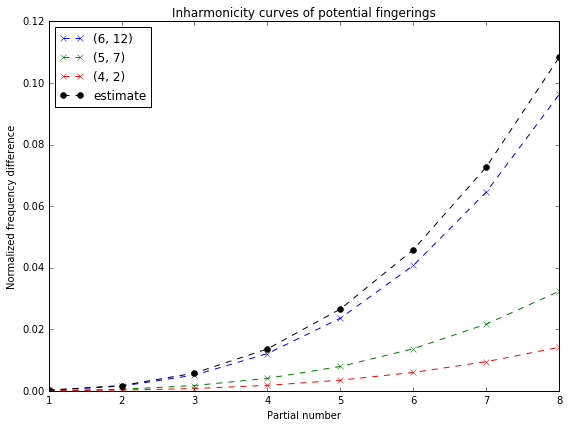


	Fingering estimated correctly!


In [89]:
# test recording parameters
str_num = 6
fret_num = 12
take_num = int(test_indices[str_num - 1, fret_num][1]) + 1

file_folder = 'string_' + str(str_num) + '/string_' + str(str_num) + '_fret_' + str(fret_num) + '/'
file_name = 'string_' + str(str_num) + '_fret_' + str(fret_num) + '_take_' + str(take_num) + '.wav'

curr_string_length = compute_string_length(string_full_length, fret_num)

print("\n\nTesting the fingering ({str_num}, {fret_num}) ...".format(str_num=str_num,fret_num=fret_num))

# read the recording
fs_recording, current_recording = wavfile.read(PATH_RECORDINGS + file_folder + file_name)
y = current_recording/max(current_recording)

# extract the first 1.5 seconds of the recording
y = y[:int(1.5*fs_recording)]

# initializations and parameters
tot_num_samp = y.shape[0]
num_samp_per_frame = int(fs_recording*frame_duration)
window = np.hamming(num_samp_per_frame)
hop_size = int(num_samp_per_frame/2)
num_frames = int((tot_num_samp-num_samp_per_frame)/hop_size)

# estimate the fundamental frequency
estimated_fundamental = estimate_fundamental(np.abs(np.fft.fft(y*np.hamming(tot_num_samp), NFFT)), fs_recording, NFFT, \
                                             tol, max_num_peaks)
print("\nEstimated fundamental [Hz]: {est_fund}".format(est_fund=estimated_fundamental))

# track the partials in successive time frames
estimated_partials, partials_amplitudes = partials_tracking(y, fs_recording, frame_duration, estimated_fundamental, \
                                                            max_mode, delta_f, partial_tracking_method, M, freq_res)

# estimate the inharmonicity coefficient
if(inharm_est_method == 'average'):
    
    # stack all the individual estimates of the inharmonicity constant
    stacked_b_hats = np.hstack([((estimated_partials[1:, n]/estimated_partials[0, n])**2 \
           - modes_num[1:]**2)/modes_num[1:]**4 for n in range(num_frames)])
    
    # remove the negative ones
    positive_b_hats = stacked_b_hats[np.where(stacked_b_hats > 0)]
    
    # compute the average
    b_hat = np.nanmean(positive_b_hats)
    
elif(inharm_est_method == 'poly'):
    
    # stack the squared, estimated frequency ratios
    stacked_freq_ratios = np.hstack([(estimated_partials[:, n]/estimated_partials[0, n])**2 for n in range(num_frames)])
    
    # fit a polynomial
    b_hat = estimate_inharmonicity_poly(1, stacked_freq_ratios, num_frames, max_mode)
    

print("\nEstimated inharmonicity constant: {b}".format(b=b_hat))

# find the best fingering using our trained model
fingering_candidates, b_candidates, best_fingering = find_best_fingering(gammas, estimated_fundamental, b_hat, string_full_length)

# visualization
num_candidates = len(b_candidates)
legend = [str(fingering_candidate) for fingering_candidate in fingering_candidates]
legend.append('estimate')

plt.figure(figsize=(8, 6))

for n in range(num_candidates):
    norm_freq_diff_candidate = (modes_num*estimated_fundamental*np.sqrt(1 + b_candidates[n]*modes_num**2) - \
        modes_num*estimated_fundamental)/estimated_fundamental
    plt.plot(modes_num, norm_freq_diff_candidate, 'x--')

norm_freq_diff_recording = (modes_num*estimated_fundamental*np.sqrt(1 + b_hat*modes_num**2) - \
        modes_num*estimated_fundamental)/estimated_fundamental
plt.plot(modes_num, norm_freq_diff_recording, 'ko--')

plt.xlabel('Partial number')
plt.ylabel('Normalized frequency difference')
plt.title('Inharmonicity curves of potential fingerings')
plt.legend(legend, loc='best')

plt.tight_layout()
plt.show()

# test if we guessed correctly
if(best_fingering != (str_num, fret_num)):
    print("\n\tError! The true fingering was {true_fing} but we decided {est_fing}".format(true_fing=(str_num, fret_num), \
                                                                                                   est_fing=best_fingering))
else:
    print("\n\tFingering estimated correctly!")

##### Testing the entire test set <br />

<div style="text-align;justified;"> In order to measure the performance of our model, we now test it on all our test recordings. </div>

In [90]:
# initializations
num_errors_per_string = np.zeros(6)

print("\nTesting our model...")

# we test all possible fingerings (over the 6 strings and the first 13 positions)
for n in range(6):
    
    print("\nString n°{str_num}".format(str_num=n+1))
    
    for m in range(13):
        
        print("\n\tFret n°{fret_num}".format(fret_num=m))
        
        # initializations for the current fingering
        file_folder = 'string_' + str(n + 1) + '/string_' + str(n + 1) + '_fret_' + str(m) + '/'
        file_name_prefix = 'string_' + str(n + 1) + '_fret_' + str(m) + '_take_'
        curr_test_idx = test_indices[n, m]
        curr_string_length = compute_string_length(string_full_length, m)
        
        # evaluate one test recording at a time
        for rec_num in curr_test_idx:
            
            # read the recording from the data folder
            file_name = file_name_prefix + str(int(rec_num + 1)) + '.wav'            
            fs_recording, current_recording = wavfile.read(PATH_RECORDINGS + file_folder + file_name)
            y = current_recording / max(current_recording)
            
            # extract the first 1.5 seconds of the recording
            y = y[:int(1.5*fs_recording)]
            
            # parameters
            tot_num_samp = y.shape[0]
            num_samp_per_frame = int(fs_recording*frame_duration)
            window = np.hamming(num_samp_per_frame)
            hop_size = int(num_samp_per_frame/2)
            num_frames = int((tot_num_samp-num_samp_per_frame)/hop_size)
            
            # estimate the fundamental frequency
            estimated_fundamental = estimate_fundamental(np.abs(np.fft.fft(y*np.hamming(tot_num_samp), NFFT)), \
                                                         fs_recording, NFFT, tol, max_num_peaks)
            
            # TMP: PROBLEM WITH THE FIRST STRING, OPEN POSITION ONLY
            if(n == 0 and m == 0):
                estimated_fundamental = 329.6
            
            print("\n\t\tEstimated fundamental [Hz]: {est_fund}".format(est_fund=estimated_fundamental))
            
            # track the partials in successive time frames
            estimated_partials, partials_amplitudes = partials_tracking(y, fs_recording, frame_duration, \
                                                                        estimated_fundamental, max_mode, delta_f, \
                                                                        partial_tracking_method, M, freq_res)
            
            # estimate the inharmonicity coefficient
            if(inharm_est_method == 'average'):
                
                # stack up all the individual estimates of the inharmonicity constant
                stacked_b_hats = np.hstack([((estimated_partials[1:, n]/estimated_partials[0, n])**2 \
                   - modes_num[1:]**2)/modes_num[1:]**4 for n in range(num_frames)])
                
                # remove the negative estimates
                positive_b_hats = stacked_b_hats[np.where(stacked_b_hats > 0)]
                
                # compute the average
                b_hat = np.nanmean(positive_b_hats)
                
            elif(inharm_est_method == 'poly'):
                
                # stack the squared frequency ratios
                stacked_freq_ratios = np.hstack([(estimated_partials[:, n]/estimated_partials[0, n])**2 for n in range(num_frames)])
                
                # polynomial fit
                b_hat = estimate_inharmonicity_poly(1, stacked_freq_ratios, num_frames, max_mode)
                
            else:
                print("Error: undefined inharmonicity estimation method.")
                break
            
            print("\t\tEstimated inharmonicity constant: {b}".format(b=b_hat))
            
            # find the best fingering using our trained model
            fingerings_candidates, b_candidates, best_fingering = find_best_fingering(gammas, estimated_fundamental, b_hat, string_full_length)
            
            # test if we guessed correctly
            if(best_fingering != (n + 1, m)):
                print("\t\t\tError! The true fingering was {true_fing} but we decided {est_fing}".format(true_fing=(n + 1, m), \
                                                                                               est_fing=best_fingering))
                num_errors_per_string[n] += 1
            else:
                print("\t\t\tFingering correctly estimated!\n")


Testing our model...

String n°1

	Fret n°0

		Estimated fundamental [Hz]: 329.6
		Estimated inharmonicity constant: 8.613838182243441e-06

		Potential fingerings: [(3, 9), (2, 5), (1, 0)]
		Corresponding inharmonicity constants: [  8.94617960e-05   8.88209878e-05   1.56581853e-05]

			Fingering correctly estimated!


		Estimated fundamental [Hz]: 329.6
		Estimated inharmonicity constant: 1.5833304336555393e-05

		Potential fingerings: [(3, 9), (2, 5), (1, 0)]
		Corresponding inharmonicity constants: [  8.94617960e-05   8.88209878e-05   1.56581853e-05]

			Fingering correctly estimated!


		Estimated fundamental [Hz]: 329.6
		Estimated inharmonicity constant: -5.1269777942435234e-08

		Potential fingerings: [(3, 9), (2, 5), (1, 0)]
		Corresponding inharmonicity constants: [  8.94617960e-05   8.88209878e-05   1.56581853e-05]

			Fingering correctly estimated!


		Estimated fundamental [Hz]: 329.6
		Estimated inharmonicity constant: 2.547610673157736e-05

		Potential fingerings: [(3, 9)

In [91]:
print("\n\nTesting phase completed!")
print("\n\tTotal number of errors (per string): {num_errors}".format(num_errors=num_errors_per_string))



Testing phase completed!

	Total number of errors (per string): [  0.  25.  17.   0.   1.   5.]


In [92]:
# OPTIONAL: store the results of the classification
#pickle.dump(num_errors_per_string, open('data_dumps/num_errors_per_string_poly', 'wb'))

### VI.V Final results <br />

<div style="text-align:justified;"> We now discuss the results of our simple classifier. </div>



Final results for both methods:


Number of misclassifications per string


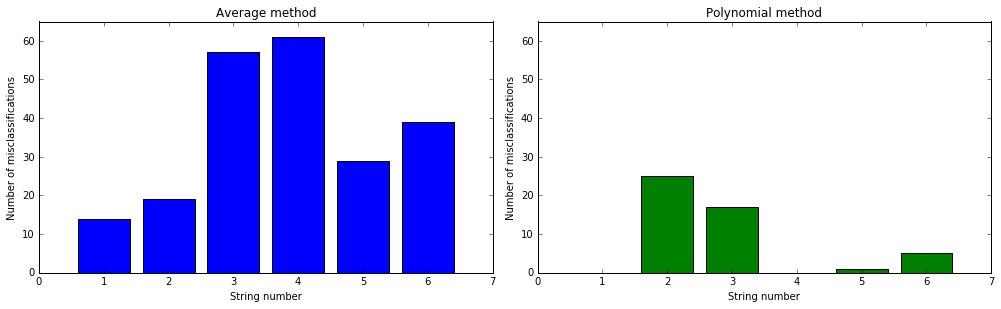


Percentage of misclassifications per string

	Average method: [ 21.53846154  29.23076923  87.69230769  93.84615385  44.61538462  60.        ]

	Polynomial method: [  0.          38.46153846  26.15384615   0.           1.53846154
   7.69230769]

Total percentage of misclassifications

	Average method: 56.154

	Polynomial method: 12.307692


In [93]:
num_errors_per_string_avg = pickle.load(open('data_dumps/num_errors_per_string_avg', 'rb'))
num_errors_per_string_poly = pickle.load(open('data_dumps/num_errors_per_string_poly', 'rb'))

print("\n\nFinal results for both methods:\n")

# number of misclassifications per string

print("\nNumber of misclassifications per string")
# visualization: bar plot of the number of errors for each string
plt.figure(figsize=(14, 8))

ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
ax1.bar(range(1, 7), num_errors_per_string_avg, color="blue", align='center')
plt.xlabel('String number')
plt.ylabel('Number of misclassifications')
plt.ylim(0, 5*13)
plt.title('Average method')

ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
ax2.bar(range(1, 7), num_errors_per_string_poly, color="green", align='center')
plt.xlabel('String number')
plt.ylabel('Number of misclassifications')
plt.ylim(0, 5*13)
plt.title('Polynomial method')

plt.tight_layout()
plt.show()

# percentage of misclassifications per string
print("\nPercentage of misclassifications per string")

percent_errors_per_string_avg = 100*num_errors_per_string_avg/(5*13)
percent_errors_per_string_poly = 100*num_errors_per_string_poly/(5*13)

print("\n\tAverage method: {percent_errors_per_string}".format(percent_errors_per_string=percent_errors_per_string_avg))
print("\n\tPolynomial method: {percent_errors_per_string}".format(percent_errors_per_string=percent_errors_per_string_poly))

# total percentage of misclassifications
print("\nTotal percentage of misclassifications")

tot_percent_errors_avg = 100*np.sum(num_errors_per_string_avg)/(6*5*13)
tot_percent_errors_poly = 100*np.sum(num_errors_per_string_poly)/(6*5*13)

print("\n\tAverage method: {tot_percent_errors:.3f}".format(tot_percent_errors=tot_percent_errors_avg))
print("\n\tPolynomial method: {tot_percent_errors:3f}".format(tot_percent_errors=tot_percent_errors_poly))

<div style="text-align:justified;"> On the above plot, we display the final results we achieved for both methods. We chose to consider the first 1.5 seconds of each recording, and the first 8 partials in frames of .75 seconds. The reason is that higher order partials are more volatile and harder to track. We used our modified Goertzel's algorithm to track the partials, as it was much faster and showed a more stable behavior. </div><br /> 

<div style="text-align:justified;"> As we can see, the second method (polynomial fit) yields much better results. With the average method, we obtained a total misclassification rate of about 56 percent, while the polynomial method gives a total of about 12.3 percent. The difference lies in the accuracy of the estimated constants $\gamma$, and more fundamentally on the estimated inharmonicity constants. Indeed, the second method showed more coherent results. Overall, our simple inharmonicity-based classifier performed relatively well. The number of misclassifications observed with the best method is however fairly high for the second and third strings (25 and 17 errors, respectively, representing 40 and 15 percents) and can be explained by the proximity of the two estimated constants $\hat{\gamma_2}$ and $\hat{\gamma_3}$. For these two, a slight imprecision in the inharmonicity estimation of a test recording will lead to a misclassification. </div>